In [36]:
import numpy as np
import torchvision.datasets as ds
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score


class Input:
	# input shape: (batch_size, #features)
	# output shape: (batch_size, #features)

	def __init__(self, inputFeatures) -> None:
		self.inputShape = (-1, inputFeatures)
		self.outputShape = self.inputShape

	def forward(self, x):
		return x

	def backward(self, gradientLossWRTOutput, _):
		return gradientLossWRTOutput, None

	def getWeights(self):
		return None



class Dense:
	# input shape: (batch_size, #features)
	# output shape: (batch_size, #nodes)

	def __init__(self, numNodes) -> None:
		self.numNodes = numNodes

	# input shape: (batch_size, #features)
	def initPipeline(self, inputShape):
		inputFeatures = inputShape[1]
		self.features = inputFeatures

		# self.weights = np.random.randn(self.numNodes, inputFeatures)
		self.weights = np.random.uniform(-.3, .3, (self.numNodes, inputFeatures))

		# self.weights = np.ones((self.numNodes, inputFeatures))
		# print(self.weights.shape)
		# self.bias = np.random.randn(self.numNodes, 1)
		self.bias = np.random.uniform(-.3, .3, (self.numNodes, 1))

		# self.bias = np.ones((self.numNodes, 1))
		# print(self.bias.shape)
		self.outputShape = (-1, self.numNodes)

	# x shape: (batch_size, #features)
	def forward(self, x):
		self.x = x
		self.y = np.dot(self.weights, x.T) + self.bias
		self.y = self.y.T
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #nodes)

	def backward(self, gradientLossWRTOutput,optimizer):

		gradientLossWRTInput = np.dot(gradientLossWRTOutput, self.weights)


		gradientLossWRTWeights = np.dot(gradientLossWRTOutput.T, self.x)
		gradientLossWRTBias = np.sum(gradientLossWRTOutput, axis = 0, keepdims=True).T

		# print(f"gradientLossWRTWeights : {gradientLossWRTWeights.shape}")
		# print(f"gradientLossWRTbias : {gradientLossWRTBias.shape}")


		self.weights = optimizer.update(self.weights, gradientLossWRTWeights)
		self.bias = optimizer.update(self.bias, gradientLossWRTBias)

		# self.weights -= learningRate * gradientLossWRTWeights
		# self.bias -= learningRate * gradientLossWRTBias

		return gradientLossWRTInput, (gradientLossWRTWeights, gradientLossWRTBias)

	def getWeights(self):
		return (self.weights, self.bias)



class Softmax:
	def __init__(self) -> None:
		pass

	# input shape: (batch_size, #features)
	# output shape: (batch_size, #features)

	def initPipeline(self, inputShape):
		self.inputShape = inputShape
		self.outputShape = inputShape

	def forward(self, x):
		self.x = x
		# print(self.x)
		# print(np.max(self.x))
		self.y =  np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #features)

	def backward(self, gradientLossWRTOutput, _):
		# gradientOutputWRT

		n , m = self.y.shape

		gradientOutputWRTInput = np.repeat(self.y, m, axis=0).reshape(n, m, m)
		gradientOutputWRTInput = np.multiply(gradientOutputWRTInput, np.transpose(gradientOutputWRTInput, axes=(0, 2, 1))) * -1

		diagElems = np.reshape(self.y, (n,  m , 1))
		diagElems = diagElems * (1 - diagElems)
		diagElems = np.eye(m) * diagElems
		mask = np.eye(m, dtype=bool)
		mask = np.tile(mask, (n, 1)).reshape(n, m, m)
		gradientOutputWRTInput[mask] = 0
		gradientOutputWRTInput = gradientOutputWRTInput + diagElems

		# jacobian_matrix = np.zeros((n, m, m))

		# for i in range(n):
		# 	# s = np.exp(self.x[i]) / np.sum(np.exp(self.x[i]), axis=1, keepdims=True)
		# 	s = self.y[i]
		# 	for j in range(n):
		# 		for k in range(n):
		# 			jacobian_matrix[i, j, k] = s[j] * (int(j == k) - s[k])


		# print(np.isclose(jacobian_matrix, gradientOutputWRTInput).all())
		# print(f"gradientLossWRTOutput : {np.expand_dims(gradientLossWRTOutput, -1).shape}")


		gradientLossWRTInput = np.matmul(gradientOutputWRTInput, np.expand_dims(gradientLossWRTOutput, -1))
		gradientLossWRTInput = np.squeeze(gradientLossWRTInput)

		# print(f"gradientLossWRTInput : {gradientLossWRTInput.shape}")

		return gradientLossWRTInput, None

	def getWeights(self):
		return None


class Relu:

	def __init__(self) -> None:
		pass

	def initPipeline(self, inputShape):
		self.inputShape = inputShape
		self.outputShape = inputShape

	def forward(self, x):
		self.x = x
		self.y = np.maximum(x, 0)
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #features)
	def backward(self, gradientLossWRTOutput, _):
		gradientOutputWRTInput = np.where(self.x > 0, 1, 0)
		gradientLossWRTInput = np.multiply(gradientOutputWRTInput, gradientLossWRTOutput)
		return gradientLossWRTInput, None

	def getWeights(self):
		return None



class Model:
	EPSILON = .000001
	def __init__(self, *layers) -> None:
		self.nLayers = len(layers)

		for i in range(1, self.nLayers):
			layers[i].initPipeline(layers[i-1].outputShape)

		self.layers = layers

	def predict(self, x):
		for layer in self.layers:
			x = layer.forward(x)
		return x

	def crossEntropyGradient(self, yTrue, yPred):
		ypc = yPred.copy()
		ypc[ypc < Model.EPSILON] = Model.EPSILON
		return - yTrue / ypc

	def __backprop(self,yTrue, yPred, optimizer):
		gradientLossWRTOutput = self.crossEntropyGradient(yTrue, yPred)
		# gradientLossWRTOutput = self.squaredErrorGradient(yTrue, yPred)
		# print(gradientLossWRTOutput)

		# print(f"loss grad wrt yhat : {gradientLossWRTOutput.shape}")
		# wAndg = []
		for layer in reversed(self.layers):
			gradientLossWRTOutput, g = layer.backward(gradientLossWRTOutput, optimizer)
			# wAndg.append((layer.getWeights(), g))


	def crossEntropyLoss(self, yPred, yTrue):
		ypc = yPred.copy()
		ypc[ypc < Model.EPSILON] = Model.EPSILON
		return -np.sum(yTrue * np.log(ypc))


		# return wAndg

	def train(self, x, y, optimizer, epoch, batchSize):

		for i in range(epoch):
			numExa = x.shape[0]

			xy = list(zip(x, y))
			np.random.shuffle(xy)

			x, y = zip(*xy)

			x = np.array(x)
			y = np.array(y)

			numExa = x.shape[0]
			numBatches = numExa // batchSize
			remSamples = numExa % batchSize



			xB = np.array_split(x[:numBatches * batchSize], numBatches)
			yB = np.array_split(y[:numBatches * batchSize], numBatches)

			if remSamples > 0:
				xB.append(x[-remSamples:])
				yB.append(y[-remSamples:])
				numBatches += 1

			for i in range(numBatches):
				xc = xB[i]
				yc = yB[i]

				yPred = self.predict(xc)
				self.__backprop(yc, yPred, optimizer)

				print(f"loss : {self.crossEntropyLoss(yc, yPred)}")


	def squaredErrorGradient(self, yTrue, yPred):
		return -2 * (yTrue - yPred)




class GradientDescent:
	def __init__(self, learningRate) -> None:
		self.learningRate = learningRate

	def update(self, w, g):
		return w - self.learningRate * g

class Emnist:
	def __init__(self, path):
		self.train = ds.EMNIST(root = path, split = 'letters', train = True, transform = transforms.ToTensor(), download = True)
		self.test = ds.EMNIST(root = path, split = 'letters', train = False, transform = transforms.ToTensor(), download = True)

	def dataTrain(self):
		return self.train.data.numpy(), self.train.targets.numpy()

	def dataTest(self):
		return self.test.data.numpy(), self.test.targets.numpy()



def eqn(x):
	return 2 * (x[0] ** 2) + 3.5 * x[1] + 7


def oneHotEncode(yTr, yTs):
	encoder = OneHotEncoder(sparse_output=False)
	oneHotYtr = encoder.fit_transform(np.expand_dims(yTr, -1))
	oneHotYts = encoder.transform(np.expand_dims(yTs, -1))

	return oneHotYtr, oneHotYts

def normalize(x):
	return x / 255

def flatten(x):
	return np.reshape(x, (x.shape[0], -1))

def getModel(numFeatures, output):
	model = Model(
			Input(numFeatures),
			Dense(64),
			Relu(),
			Dense(64),
			Relu(),
			Dense(32),
			Relu(),
			Dense(output),
			Softmax()
	)

	return model

def acc(model, x, yTrue):
	yPred = model.predict(x)
	yPred = np.argmax(yPred, axis = 1)
	yTrue = np.argmax(yTrue, axis = 1)
	return accuracy_score(yTrue, yPred)


def main():
	np.random.seed(13)
	dataset = Emnist('/content/')
	trX, trY = dataset.dataTrain()
	tsX, tsY = dataset.dataTest()

	# print(trX.shape)

	trY, tsY = oneHotEncode(trY, tsY)

	trX = normalize(trX)
	tsX = normalize(tsX)

	trX = flatten(trX)
	tsX = flatten(tsX)


	tX, vX, tY, vY = train_test_split(trX, trY, test_size = .15, random_state = 29)

	print(tX.shape, tY.shape)
	print(vX.shape, vY.shape)


	model = getModel(tX.shape[1], tY.shape[1])

	optimizer = GradientDescent(.0001)

	epoch = 10
	batchSize = 256

	print(tX.shape, tY.shape)

	model.train(tX, tY, optimizer, epoch, batchSize)

	print(f"train accuracy : {acc(model, tX, tY)}")
	print(f"validation accuracy : {acc(model, vX, vY)}")
	# print(f"test accuracy : {acc(model, tsX, tsY)}")




main()

(106080, 784) (106080, 26)
(18720, 784) (18720, 26)
(106080, 784) (106080, 26)
loss : 3411.6916579500285
loss : 3408.3603031720713
loss : 3395.635924552164
loss : 3401.702655924798
loss : 3393.7789288860204
loss : 3396.4911279068665
loss : 3393.392980504118
loss : 3385.0094291571368
loss : 3390.2725648275746
loss : 3399.5648266795915
loss : 3392.8334315218817
loss : 3391.934002757528
loss : 3386.8337907711198
loss : 3394.312707475501
loss : 3394.0790479153184
loss : 3382.5250813615457
loss : 3388.0128165847273
loss : 3380.229889120419
loss : 3385.341306353671
loss : 3386.851919435112
loss : 3388.953181771123
loss : 3382.371844400179
loss : 3387.4053903736108
loss : 3385.3717178595252
loss : 3378.997531745803
loss : 3385.7028061862957
loss : 3394.9146811517676
loss : 3374.731030772601
loss : 3375.965229934952
loss : 3369.119169092427
loss : 3382.2653951428492
loss : 3374.6222533419254
loss : 3370.7657354737385
loss : 3377.389191964887
loss : 3371.0565316534535
loss : 3373.1689886571885


In [144]:
import torchvision.datasets as ds
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [292]:
train = ds.EMNIST(root = '/content/', split = 'letters', train = True, transform = transforms.ToTensor(), download = True)
test = ds.EMNIST(root = '/content/', split = 'letters', train = False, transform = transforms.ToTensor(), download = True)

In [293]:
test.data.shape

torch.Size([20800, 28, 28])

In [145]:
train

Dataset EMNIST
    Number of datapoints: 124800
    Root location: /content/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [48]:
(train.targets == 26).any()

tensor(True)

In [5]:
train.data.shape

torch.Size([124800, 28, 28])

In [ ]:
train.data[0]

In [63]:
encoder = OneHotEncoder(sparse=False)
oneHotEncoded = encoder.fit_transform(np.expand_dims(train.targets, -1))
# print(one_hot_encoded.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [284]:
tX, vX, tY, vY = train_test_split(train.data, oneHotEncoded, test_size = .15, random_state = 29)

In [285]:
tX.shape

torch.Size([106080, 28, 28])

In [286]:
tY.shape

(106080, 26)

In [67]:
def plot(img):
  plt.imshow(img, cmap = 'gray')
  plt.show()

In [68]:
def randomPlot(x, y):
  num_images = x.shape[0]
  indices = np.random.choice(num_images, 16, replace=False)

  # Plotting 16 random images
  plt.figure(figsize=(8, 8))
  for i, index in enumerate(indices, 1):
      plt.subplot(4, 4, i)
      plt.imshow(x[index], cmap='gray')
      plt.title(f"{chr(np.argmax(y[index]) + ord('a') )}", fontsize=10)
      plt.axis('off')

  plt.tight_layout()
  plt.show()

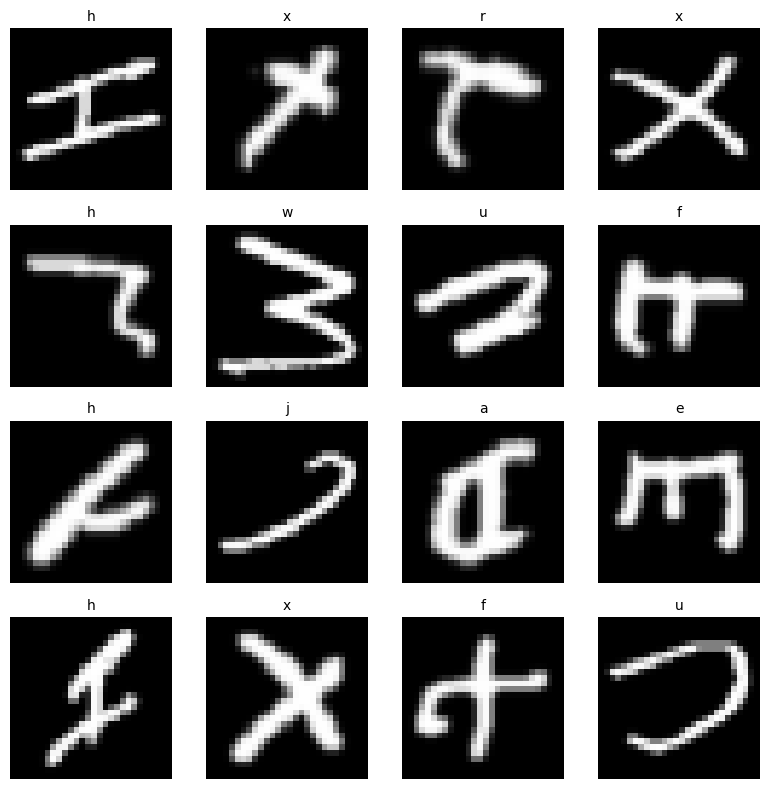

In [152]:
randomPlot(tX, tY)

In [279]:
def acc(model, x, yTrue):
  yPred = model.predict(x)
  yPred = np.argmax(yPred, axis = 1)
  yTrue = np.argmax(yTrue, axis = 1)
  return accuracy_score(yTrue, yPred)

In [287]:
np.random.seed(13)
x = np.copy(tX)
y = np.copy(tY)

numExamples = x.shape[0]
x = np.reshape(x, (numExamples, -1))
print(x.shape)
numFeatures = x.shape[1]

model = Model(
    Input(numFeatures),
    Dense(256),
    Relu(),
    Dense(128),
    Relu(),
    Dense(64),
    Relu(),
    Dense(32),
    Relu(),
    Dense(26),
    Softmax()
)


n = x.shape[0]
xs = x[0:n] / 255
ys = y[0:n]

print(acc(model, xs, ys))

model.train(xs,ys, GradientDescent(.001), 10, 256)

print(acc(model, xs, ys))

(106080, 784)
0.035407239819004524
loss : 3391.3012106426368
loss : 3410.770780598984
loss : 3421.526722380484
loss : 3412.1259382806056
loss : 3394.273714355624
loss : 3390.238125676434
loss : 3378.4887001895277
loss : 3377.1812738068693
loss : 3377.1005510380396
loss : 3369.3398423707313
loss : 3378.5491471248642
loss : 3358.436511808312
loss : 3371.771303658984
loss : 3369.879820418999
loss : 3347.575309884181
loss : 3349.4878799889802
loss : 3329.3337538631113
loss : 3323.510790954166
loss : 3322.206643952464
loss : 3319.6309930070793
loss : 3293.891568916232
loss : 3291.6957441795166
loss : 3271.100810854209
loss : 3282.792096157216
loss : 3256.039398949516
loss : 3242.4118811120024
loss : 3298.4968297380296
loss : 3253.6179267196667
loss : 3210.775888878593
loss : 3217.5227738112417
loss : 3200.4559438420047
loss : 3165.1004384113025
loss : 3156.1837333920457
loss : 3148.380106855806
loss : 3153.4590258058925
loss : 3119.434829354316
loss : 3024.4187002228077
loss : 3047.80287696

In [288]:
print(acc(model, np.reshape(vX, (vX.shape[0], -1)) / 255, vY ))

0.8771901709401709
